# Trials

In [ ]:
'Acc-order,2 and 0 give less accurate results'
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = 64
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

#Data on 1000 time-steps
init_values=np.sin(x_fine)
CFL=0.08
u0=1.
dx=grid_length/len(x_fine)
dt=dx*CFL/u0
tend=15.
N_t=int(tend//dt)

(64, 1)


In [ ]:
for x,y in zip([1,2,3],['a','b','c']):
  print(x,y)

1 a
2 b
3 c


In [ ]:
def ic(A,K,PHI,x_mesh):
  u=np.zeros_like(x_mesh)
  for A1,k1 in zip(A,K):
    for phi1 in PHI:
      u+= A1*np.sin(k1*x_mesh + phi1)
  return u
def solution_data(A,K,PHI,x_mesh,ntime,delt):
  # data_ls=[ u_ana[i]+=  amp[k1]*exp(-kappa[k1]*kappa[k1]*nu*tEnd)*sin(kappa[k1]*(x[i]-cx*tEnd)+phi[k2]) for i in range(ntime)]
  data_ls=[]
  for step in range(ntime):
    u=np.zeros_like(x_mesh)
    for A1,k1 in zip(A,K):
      for phi1 in PHI:
        u+= A1*np.sin(k1*(x_mesh-step*delt) + phi1)
    data_ls.append(u)
  data_sol=np.stack(data_ls)
  return data_sol

In [ ]:
'initS = [ Amp_list ,  k_list  , phi_list  ]'
initS=[[1,1],[1,2],[0]]

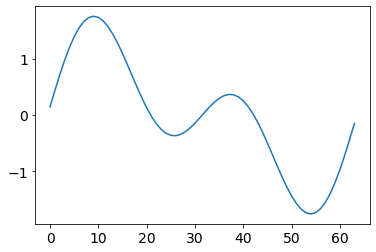

In [ ]:
plt.plot(ic([1,1],[1,2],[0],x_fine[:,0]))

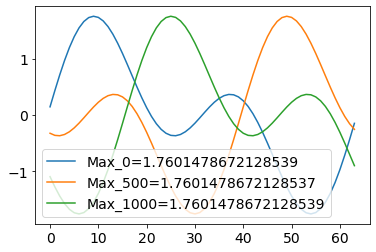

In [ ]:
plot_time_prop(solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt),0,500,1000)

In [ ]:
# x_fine[:,0]
solution_data([1],[1],[3],x_fine[:,0],N_t,dt).shape

(1909, 64)

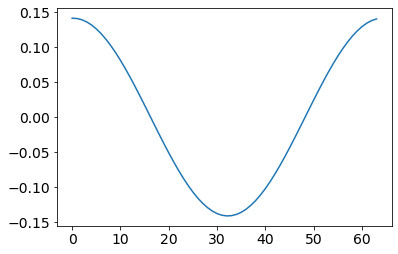

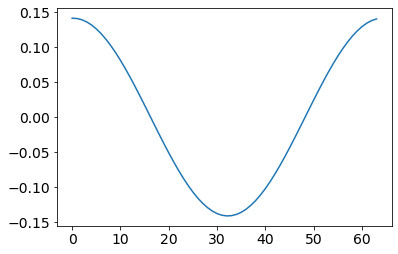

In [ ]:
# plt.plot(ic([1],[1],[0],x_fine))
plt.plot(ic([1],[1],[3],x_fine[:,0])+ic([1],[1],[0],x_fine[:,0]))
plt.show()
plt.plot(ic([1],[1],[0,3],x_fine))
plt.show()

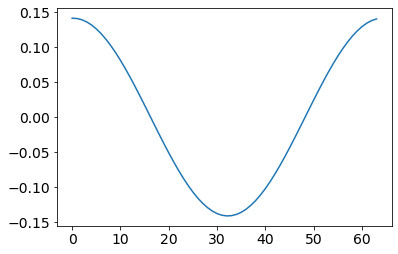

In [ ]:
plt.plot(np.sin(x_fine[:,0]+3)+np.sin(x_fine[:,0]))

In [ ]:
a,b,c=1,2,3

In [ ]:
c

3

# Tutorial with 1d advection equation

Code pipeline from the PNAS 2020 paper by Jiawei Zhuang et al. 

In [ ]:
# %%capture
# !pip install -U numpy==1.18.5
# !pip install h5py==2.10.0

In [ ]:
'Comment above cell and restart and run all before'

'Comment above cell and restart and run all before'

In [ ]:
'Check numpys version BEFORE and AFTER runtime restart'
import numpy as np
import matplotlib.pyplot as plt
print(np.__version__)

1.18.5


(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)
True


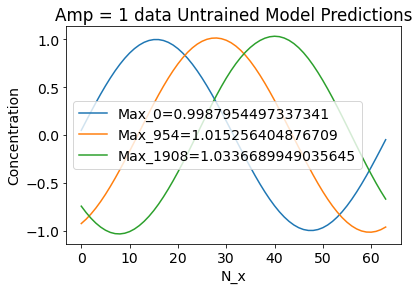

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)
Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 4.6274e-05
Epoch 2/20
1899/1899 [==============================] - 4s 2ms/sample - loss: 2.9776e-05
Epoch 3/20
1899/1899 [==============================] - 4s 2ms/sample - loss: 1.8470e-05
Epoch 4/20
1899/1899 [==============================] - 4s 2ms/sample - loss: 1.4691e-05
Epoch 5/20
1899/1899 [==============================] - 4s 2ms/sample - loss: 1.2076e-05
Epoch 6/20
1899/1899 [==============================] - 4s 2ms/sample - loss: 1.1217e-05
Epoch 7/20
1899/1899 [==============================] - 4s 2ms/sample - loss: 1.0582e-05
Epoch 8/20
1899/1899 [==============================] - 4s 2ms/sample - loss: 1.0530e-05
Epoch 9/20
1899/1899 [==================

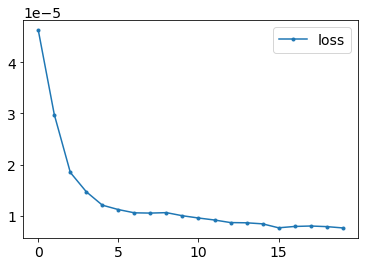

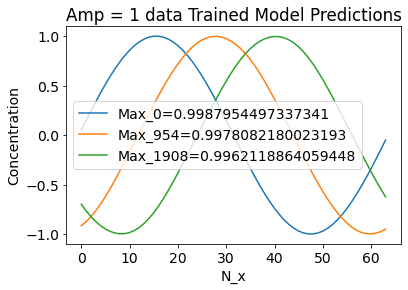

In [ ]:

res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/u0
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)
# model1=models.conv2d_stack(num_outputs=10,num_layers=5,filters=32, kernel_size=5,activation='relu')
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,
  num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=16,constrained_accuracy_order=1,
  learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
print(advection_equations.FiniteDifferenceAdvection(0.08).get_time_step(fine_grid,u0) == dt)
'Untrained Evaluation'  
integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Amp = 1 data Untrained ')

'Training'
ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
model_nn.compile(
    optimizer='adam', loss='mae'
    )
history = model_nn.fit(
    train_input, train_output, epochs=20, batch_size=64, 
    verbose=1, shuffle=True
    )
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

'Trained Evaluation'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Amp = 1 data Trained ')


In [ ]:
model_nn.call(initial_state).shape
# model_nn.fixed_keys

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:

def timestepNL(initSt,delt):
  # Every array is a numpy array 
  ct_np=np.squeeze(initSt['concentration'])

  all_key=model_nn.spatial_derivatives(initSt)
  C_x = np.squeeze(all_key['concentration_x'].numpy())

  ct1_np = ct_np + delt*(-ct_np)*(C_x)
  # ct1_np = ct_np + delt*(-C_x)
  initSt1 = copy.deepcopy(initSt)
  initSt1['concentration'][0,:,0] = ct1_np
  return ct1_np,initSt1

data_ls=[]
init_t = copy.deepcopy(initial_state)
# data_ls.append(init_t)
for i in range(100):
  # model_nn.spatial_derivatives(init_t)
  ct1,init2=timestepNL(init_t,dt)
  init_t= copy.deepcopy(init2)
  data_ls.append(ct1)


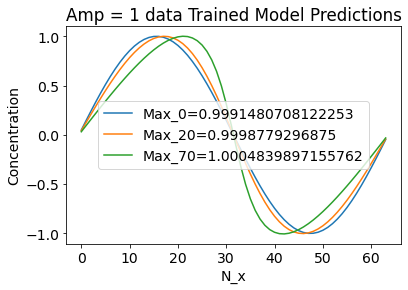

In [ ]:
plot_time_prop(data_ls,0,20,70,'Amp = 1 data Trained ')

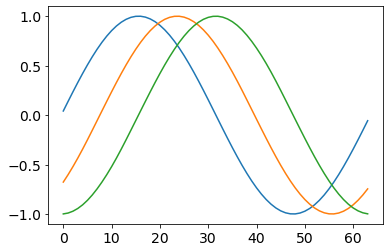

In [ ]:
plt.plot(data_ls[0])
plt.plot(data_ls[100])
plt.plot(data_ls[200])

In [ ]:
len(data_ls)

1909

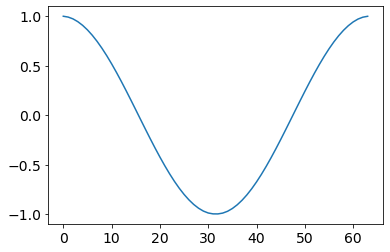

In [ ]:
outdict=model_nn.spatial_derivatives(initial_state)
# plt.plot(outdict['concentration_y'][0,:,0].numpy())
plt.plot(outdict['concentration_x'][0,:,0].numpy())
concx=np.squeeze(outdict['concentration_x'].numpy())

In [ ]:

d2=copy.deepcopy(outdict)

In [ ]:
zr=np.zeros_like(outdict['concentration'])
zr.shape

(1, 64, 1)

In [ ]:
d2['concentration']= np.zeros_like(zr)

In [ ]:
# outdict['concentration']

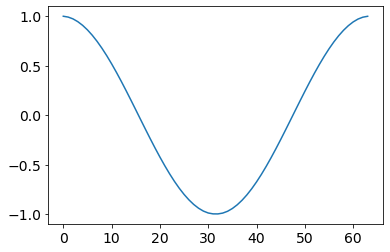

In [ ]:
plt.plot(concx)

In [ ]:
# initial_state=create_init_state_from_2d_data(data_ana,u0)

concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


In [ ]:
conct=initial_state.deepcopy()

AttributeError: ignored

In [ ]:
type(outdict['concentration_x'])

numpy.ndarray

In [ ]:
type(conct['concentration'])

numpy.ndarray

In [ ]:
2*-np.arange(3,8)*(-np.arange(5))

array([ 0,  8, 20, 36, 56])

In [ ]:
np.arange(3,8)

array([3, 4, 5, 6, 7])

In [ ]:
def timestepNL(initSt,C_x,delt):
  # Every array is a numpy array 
  ct_np=np.squeeze(initSt['concentration'])
  ct1_np = ct_np + delt*(-ct_np)*(C_x)
  initSt1 = copy.deepcopy(initSt)
  initSt1['concentration'][0,:,0] = ct1_np
  return ct1_np,initSt1


In [ ]:
conct['concentration'][0,:,0]=np.zeros(64)
conct['concentration']

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [ ]:
np.squeeze(initial_state['concentration'])

array([ 0.04906768,  0.14673047,  0.24298018,  0.33688986,  0.42755508,
        0.51410276,  0.5956993 ,  0.671559  ,  0.7409511 ,  0.8032075 ,
        0.8577286 ,  0.9039893 ,  0.94154406,  0.97003126,  0.9891765 ,
        0.99879545,  0.99879545,  0.9891765 ,  0.97003126,  0.94154406,
        0.9039893 ,  0.8577286 ,  0.8032075 ,  0.7409511 ,  0.671559  ,
        0.5956993 ,  0.51410276,  0.42755508,  0.33688986,  0.24298018,
        0.14673047,  0.04906768, -0.04906768, -0.14673047, -0.24298018,
       -0.33688986, -0.42755508, -0.51410276, -0.5956993 , -0.671559  ,
       -0.7409511 , -0.8032075 , -0.8577286 , -0.9039893 , -0.94154406,
       -0.97003126, -0.9891765 , -0.99879545, -0.99879545, -0.9891765 ,
       -0.97003126, -0.94154406, -0.9039893 , -0.8577286 , -0.8032075 ,
       -0.7409511 , -0.671559  , -0.5956993 , -0.51410276, -0.42755508,
       -0.33688986, -0.24298018, -0.14673047, -0.04906768], dtype=float32)

In [ ]:
timestepNL(initial_state,concx,dt)[0].shape

(1, 64, 64)

In [ ]:
for i in range(N_t):
  

In [ ]:
'''Steps for using Linear model in Non -Linear Equation
1. Create model_NN as already given 
2. Train and Validate it on several datasets

Note : Prelim analysis assume model_nn has has been trained

3.Get spatial derivatives only using model_nn
/ 3b - Using these spatial derivatives directly to time-step custom 

4. Take-Time-Step using non linear eqn. using these spatial derivatives 
5. Create new integrate function class to integrate in time 

ALSO CHECK COEFFICIENT SWITCHING

'''

In [ ]:
outdict=model_nn.spatial_derivatives(initial_state)
outdict.keys()

dict_keys(['concentration_x', 'concentration_y', 'y_velocity', 'concentration', 'x_velocity'])

In [ ]:
eq = NonLinAdvection(dt)
sdm = models.SpatialDerivativeModel(equation=eq ,grid = fine_grid)

In [ ]:
eq.take_time_step(fine_grid,outdict['concentration_x'])

TypeError: ignored

In [ ]:
# sdm.take_time_step(initial_state,outdict)

In [ ]:
# key_definitions

In [ ]:
'''
==> Burgers Equation Object define 

'''

In [ ]:
fine_grid

Grid(size_x=64, size_y=1, step=0.09817477042468103)

In [ ]:
# len(set())

In [ ]:
sdm = models.SpatialDerivativeModel(equation=eq ,grid = fine_grid)

In [ ]:
sdm.spatial_derivatives(initial_state)

NotImplementedError: ignored

In [ ]:
sdm.time_derivative(initial_state)

NotImplementedError: ignored

In [ ]:
for k in initial_state:
  print(k)

concentration
x_velocity
y_velocity


In [ ]:
type(models.sorted_values(initial_state)[0])

numpy.ndarray

In [ ]:
x_=models.stack_dict(initial_state)
x_.shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(3)])

In [ ]:
models.stack_dict(initial_state)

In [ ]:
conv=models.Conv2DPeriodic(5,3)
conv(x_).shape

TensorShape([Dimension(1), Dimension(32), Dimension(1), Dimension(5)])

In [ ]:
a=tf.constant(1)
b=tf.constant(2)
c=a+b
print(c)

tf.Tensor(3, shape=(), dtype=int32)


In [ ]:
tf.__version__

'1.15.2'

In [ ]:


def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(models.stack_dict))
  for _ in range(1):
    layer = models.Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(models.Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model

In [ ]:
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,
  num_time_steps=4,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=16,constrained_accuracy_order=1,
  learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
model_nn.call(initial_state).shape

TensorShape([Dimension(1), Dimension(4), Dimension(64), Dimension(1)])

In [ ]:
x1=tf.ones(32,3)

In [ ]:
init2=initial_state.copy()

In [ ]:
init2['zz']=np.zeros_like(initial_state['concentration'])

In [ ]:
init2.keys()

dict_keys(['concentration', 'x_velocity', 'y_velocity', 'zz'])

In [ ]:
cstack=conv2d_stack(num_outputs=12, num_layers=5, filters=32, kernel_size=3,
                 activation='relu')
# cstack(x_)
# type(cstack)
# tf.enable_eager_execution()
# with tf.Session() as sess : 
# inputs = tf.keras.Input(shape=(32))
# inputs
# cstack.build(inputs)
  # cstack.summary()
net_out=cstack(initial_state)
net_out.shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(12)])

In [ ]:
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,
  num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=16,constrained_accuracy_order=1,
  learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
model_nn.call(initial_state).shape
# model_nn.fixed_keys

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
outl = models.build_output_layers(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid, {'concentration_x', 'concentration_y'}, stencil_size =3 , initial_accuracy_order =1 
                                  ,constrained_accuracy_order =1 , layer_cls=models.VaryingCoefficientsLayer,predict_permutations=True)
print(outl)
for key in outl:
  print(outl[key].kernel_size)

{'concentration_x': <datadrivenpdes.core.models.VaryingCoefficientsLayer object at 0x7fc09f34fd50>, 'concentration_y': <datadrivenpdes.core.models.VaryingCoefficientsLayer object at 0x7fc09f34ffd0>}
6
6


In [ ]:
num_o = sum(layer.kernel_size for layer in outl.values())
num_o

12

In [ ]:
hds=tf.split(net_out, [6,6], axis=-1)
len(hds)

2

In [ ]:
result={}
for (key,layer),hd in zip(outl.items(),hds):
  # initial_state[layer.input_key]
  # print(initial_state[layer.input_key].shape)
  input_ten = initial_state['concentration']
  # hd == head == mask 
  # print(layer.input_key)
  result[key]=layer([hd,input_ten])


In [ ]:
if model_nn.fixed_keys:
  print(True)

True


In [ ]:
outdict=model_nn.spatial_derivatives(initial_state)

In [ ]:
outdict.keys()

dict_keys(['concentration_x', 'concentration_y', 'y_velocity', 'concentration', 'x_velocity'])

In [ ]:
for val in outdict.values():
  print(val.shape)

(1, 64, 1)
(1, 64, 1)
(1, 64, 1)
(1, 64, 1)
(1, 64, 1)


In [ ]:
# models.average_over_transforms(models.PseudoLinearModel(initial_state)._apply_model, [geometry.Identity()], initial_state)

TypeError: ignored

In [ ]:
1 or None

1

In [ ]:
def spatial_derivatives(modelNN=model_nn,init3=initial_state):
  """See base class."""
  resultnew = models.average_over_transforms(
      modelNN._apply_model(init3), [geometry.Identity()], init3
  )
  # if self.fixed_keys:
  #   result.update(
  #       self.fd_model.spatial_derivatives(inputs, self.fixed_keys)
  #   )
  return resultnew

In [ ]:
spatial_derivatives()


TypeError: ignored

In [ ]:
result.values()

dict_values([<tf.Tensor: id=774, shape=(1, 64, 1), dtype=float32, numpy=
array([[[ 0.9972493 ],
        [ 0.9877324 ],
        [ 0.96862805],
        [ 0.94026965],
        [ 0.9027337 ],
        [ 0.8564041 ],
        [ 0.8017171 ],
        [ 0.7393241 ],
        [ 0.66949934],
        [ 0.59317565],
        [ 0.511115  ],
        [ 0.42417073],
        [ 0.33311188],
        [ 0.23885573],
        [ 0.14242102],
        [ 0.04475635],
        [-0.05318074],
        [-0.15046357],
        [-0.24619384],
        [-0.33943263],
        [-0.4293075 ],
        [-0.51498103],
        [-0.5956912 ],
        [-0.6706801 ],
        [-0.7393076 ],
        [-0.80115414],
        [-0.85535526],
        [-0.9014617 ],
        [-0.93885463],
        [-0.967571  ],
        [-0.98701066],
        [-0.99699074],
        [-0.99742985],
        [-0.9883571 ],
        [-0.9698726 ],
        [-0.942072  ],
        [-0.90514046],
        [-0.85949093],
        [-0.80553204],
        [-0.74360806],
       

In [ ]:

type(result)
        

dict

<Identity>

In [ ]:
initial_state['concentration'].shape

(1, 32, 1)

In [ ]:
model1.call([3.])

IndexError: ignored

In [ ]:
# initial_state['concentration']

In [ ]:
model1.call(
    initial_state['concentration'])

TypeError: ignored

# Setup

In [ ]:
%%capture
# !git clone https://github.com/aditya5252/Multiprocessor_Advection_.git
!pip install git+https://github.com/JiaweiZhuang/data-driven-pdes@fix-beam
%tensorflow_version 1.x

import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from google.colab import files  # colab-specific utilities; comment out when running locally

tf.enable_eager_execution()

tf.__version__, tf.keras.__version__
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils
from datadrivenpdes.core import geometry
# tf.keras.backend.set_floatx('float32')
import copy

In [ ]:
from datadrivenpdes.core import equations as eqn
from datadrivenpdes.core import states
from datadrivenpdes.core import polynomials
class NonLinAdvection(eqn.Equation):

    DISCRETIZATION_NAME = 'finite_difference'
    METHOD = polynomials.Method.FINITE_DIFFERENCE
    MONOTONIC = False
    CONTINUOUS_EQUATION_NAME = 'NLAdvection'

    key_definitions = {
        'A': states.StateDefinition(name='A',
                      tensor_indices=(),
                      derivative_orders=(0,0,0),
                      offset=(0,0)),
        'A_x': states.StateDefinition(name='A',
                         tensor_indices=(),
                         derivative_orders=(1, 0, 0),
                         offset=(0, 0)),
          }
    evolving_keys = {'A',}
    constant_keys = set()

    def __init__(self,timestep):
        self._timestep = timestep
        super().__init__()
    
    def time_derivative(
          self, grid, A, A_x):
        """See base class."""
        rA = -A*A_x
        return {'A': rA,}


In [ ]:
np.arange(6)[np.newaxis,:,np.newaxis].shape

(1, 6, 1)

In [ ]:
np.arange(24).reshape(4,6)[0][np.newaxis,:,np.newaxis].shape

(1, 6, 1)

In [ ]:
def ic(A,K,PHI,x_mesh):
  u=np.zeros_like(x_mesh)
  for A1,k1 in zip(A,K):
    for phi1 in PHI:
      u+= A1*np.sin(k1*x_mesh + phi1)
  return u

def solution_data(A,K,PHI,x_mesh,ntime,delt):
  # data_ls=[ u_ana[i]+=  amp[k1]*exp(-kappa[k1]*kappa[k1]*nu*tEnd)*sin(kappa[k1]*(x[i]-cx*tEnd)+phi[k2]) for i in range(ntime)]
  data_ls=[]
  for step in range(ntime):
    u=np.zeros_like(x_mesh)
    for A1,k1 in zip(A,K):
      for phi1 in PHI:
        u+= A1*np.sin(k1*(x_mesh-step*delt) + phi1)
    data_ls.append(u)
  data_sol=np.stack(data_ls)
  return data_sol

'Find dt for Advection-1d equation'
def _dx_dt(data,adv_coff):
    dx=2*np.pi/(data.shape[1])
    return dx,dx*0.08/adv_coff

'Plot time propagation of dataset'
def plot_time_prop(data,t0,t1,t2,tr='UnTrained'):
  plt.plot(data[t0],label=f'Max_{t0}={data[t0].max()}')
  plt.plot(data[t1],label=f'Max_{t1}={data[t1].max()}')
  plt.plot(data[t2],label=f'Max_{t2}={data[t2].max()}')
  plt.ylabel('Concentration')
  plt.xlabel('N_x')
  plt.title(tr+'Model Predictions')
  plt.legend()
  plt.show()



'Create initial_state dictionary from dataset'
def create_init_state_from_2d_data(data,adv_coff):
  c_init=data[0][np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': adv_coff*np.ones(c_init.shape, np.float32) * 1.0,
      'y_velocity': np.zeros(c_init.shape, np.float32)
  }

  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj


def create_init_state_from_Burger_init(c_data):
  c_init=c_data[np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': c_init.astype(np.float32),
      'y_velocity': np.zeros(c_init.shape, np.float32)}
  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj

'Create xarray DatArray from integrated dictionary'
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated['concentration'].numpy().squeeze(-1),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse.squeeze()}
  )
  return dr

def plotOOA(m,c,ls,err_ls):
  plt.plot(np.log(ls),-m*np.log(ls)+c,'r',label=f'{m}order accurate')
  plt.plot(np.log(ls),np.log(err_ls),'b',label='Log-Error')
  plt.xlabel('LogNx')
  plt.ylabel('LogError')
  plt.legend()
  plt.title('Order of Accuracy Plot')
  plt.show()
def delay_(max_delay,prob_dist):
  allowed_delays=np.arange(0.,max_delay)
  delay_chosen=choice(allowed_delays,p=prob_dist)
  return delay_chosen

def modify_data(sub_data,DAsync=None):
  one_arr=np.ones_like(sub_data)

  boundary_arr=np.zeros_like(sub_data)
  boundary_arr[:,0]=1.
  boundary_arr[:,-1]=1.

  if (DAsync==0):
    delay_arr=np.zeros_like(sub_data)
  elif (DAsync==1):
    delay_arr=np.zeros_like(sub_data)
    for i in range(delay_arr.shape[0]):
      delay_arr[i,0]=delay_(nlevels,prob_set)
      delay_arr[i,-1]=delay_(nlevels,prob_set)

  del_arr = delay_arr + boundary_arr + one_arr 
  sub_data_modified=np.multiply(del_arr,sub_data)

  return sub_data_modified


In [ ]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):
  'What does this function do'
  'Runs high-accuracy model at high-resolution'
  'smaller dx, => More Nx   => More Nt'
  'Subsample with  subsampling_factor=Resamplingfactor '
  'High accuracy data achieved on a coarse grid'
  'So essentially obtain coarse-grained, HIGH-ACCURACY, GROUND TRUTH data'
  'Return dict of items'


  'For my simple use-case , Resamplingfactor = 1 '
  'Hence, given sync_data dataset(128 x 32)'
  'sync_data dataset itself is taken as the ground truth'
  'Hence we do not need this function to obtain Ground truth data '

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.08)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


In [ ]:
def ground_dict_from_data(data):
  conc_ground=tf.convert_to_tensor(data[:,np.newaxis,:,np.newaxis], dtype=tf.float32, dtype_hint=None, name=None)
  ground_soln_dict = {
      'concentration': conc_ground,  # tensorflow code expects float32
      'x_velocity': tf.ones_like(conc_ground, dtype=None, name=None) * 1.0,
      'y_velocity': tf.zeros_like(conc_ground, dtype=None, name=None)
  }
  for k, v in ground_soln_dict.items():
    print(k, v.shape)   # (sample, x, y)
  return ground_soln_dict

def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

# Define Grids & Get Data from Analytical Solution

In [ ]:
# we mostly run simulation on coarse grid
# the fine grid is only for obtaining training data and generate the reference "truth"
def vary_ks(sten_size,k_size,beginL=4,endL=7):
  err_ls=[]
  for ord in range(beginL,endL):
    res=2**ord
    numPE=1
    grid_length = 2*np.pi
    fine_grid_resolution = res
    # 1d domain, so only 1 point along y dimension
    fine_grid = grids.Grid(
        size_x=fine_grid_resolution, size_y=1, 
        step=grid_length/fine_grid_resolution
        )
    x_fine, _ = fine_grid.get_mesh()
    print(x_fine.shape)
    
    CFL,u0,tend=0.08,1.,15.
    dx=grid_length/len(x_fine)
    dt=dx*CFL/u0
    N_t=int(tend//dt)
    initS=[[1],[1],[0]]
    data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
    'Create initial state from data'
    initial_state=create_init_state_from_2d_data(data_ana,u0)

    model_nn = models.PseudoLinearModel(
      advection_equations.FiniteDifferenceAdvection(0.08), 
      fine_grid,
      num_time_steps=4,  # multi-step loss function
      stencil_size=sten_size, kernel_size=(k_size,1), num_layers=5, filters=16,
      constrained_accuracy_order=1, 
      learned_keys = {'concentration_x', 'concentration_y'},  # finite volume view, use edge concentration
      activation='relu',)
    
    print(advection_equations.FiniteDifferenceAdvection(0.08).get_time_step(fine_grid,u0) == dt)
    tf.random.set_random_seed(14)
    time_steps=np.arange(N_t)
    # %time 
    integrated_untrained = integrate.integrate_steps(model_nn, initial_state, time_steps)
    plot_time_prop(integrated_untrained['concentration'].numpy().squeeze(),0,N_t//2,N_t-1)
    plt.ylabel('Concentration')
    plt.xlabel('N_x')
    plt.title('Untrained Model Predictions')
    plt.show()

    ground_soln_dict=ground_dict_from_data(data_ana)
    train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 4)
    # %%time 
    # same as training standard Keras model
    model_nn.compile(
        optimizer='adam', loss='mae'
        )

    # tf.random.set_random_seed(42)
    # np.random.seed(42)
    history = model_nn.fit(
        train_input, train_output, epochs=20, batch_size=64, 
        verbose=0, shuffle=True
        )
    df_history = pd.DataFrame(history.history)
    df_history.plot(marker='.')
    plt.show()
    time_steps=np.arange(N_t)
    # %time 
    integrated_trained = integrate.integrate_steps(model_nn, initial_state, time_steps)
    plot_time_prop(integrated_trained['concentration'].numpy().squeeze(),0,N_t//2,N_t-1)
    plt.ylabel('Concentration')
    plt.xlabel('N_x')
    plt.title('Trained Model Predictions')
    plt.show()
    erAr=integrated_trained['concentration'].numpy().squeeze()[N_t-1]-data_ana[N_t-1]
    err_=np.mean(np.abs(erAr))
    err_ls.append(err_)
    
  err_ls=np.array(err_ls)  
  ls=np.array([2**i for i in range(4,8)])
  # print(ls)
  # print(np.log(ls))
  plotOOA(0,0,ls,err_ls)
  plotOOA(1,0,ls,err_ls)
  plotOOA(2,5,ls,err_ls)
  plotOOA(3,7,ls,err_ls)

# Multi-variate variation function
Train on Init-1 & Validate on Init-2

In [ ]:

def validate_k_a_p(kernel,init1,init2,ep=20,sd=0):
  'Define params'
  fine_grid_resolution,grid_length =2**5,2*np.pi
  fine_grid = grids.Grid(
      size_x=fine_grid_resolution, size_y=1, 
      step=grid_length/fine_grid_resolution
      )
  x_fine, _ = fine_grid.get_mesh()
  CFL,u0,tend=0.08,1.,15.
  dx=grid_length/len(x_fine)
  dt=dx*CFL/u0
  N_t=int(tend//dt)
  time_steps=np.arange(N_t)

  data1=solution_data(init1[0],init1[1],init1[2],x_fine[:,0],N_t,dt)
  initial_state1=create_init_state_from_2d_data(data1,u0)
  initial_state2=create_init_state_from_Burger_init(np.sin(x_fine[:,0]))

  model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,
    num_time_steps=4,stencil_size=3, kernel_size=(kernel,1), num_layers=5, filters=16,constrained_accuracy_order=1,
    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
  print(advection_equations.FiniteDifferenceAdvection(0.08).get_time_step(fine_grid,u0) == dt)
  tf.random.set_random_seed(sd)

  'Untrained Evaluation'  
  integrated_UT1 = integrate.integrate_steps(model_nn, initial_state1, time_steps)
  plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Amp = 1 data Untrained ')
  integrated_UT2 = integrate.integrate_steps(model_nn, initial_state2, time_steps)
  plot_time_prop(integrated_UT2['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Amp = 20 data Untrained ')

  'Training'
  ground_soln_dict=ground_dict_from_data(data1)
  train_input, train_output = make_train_data(ground_soln_dict,data1.shape[0]-1, 4)
  model_nn.compile(
      optimizer='adam', loss='mae'
      )
  history = model_nn.fit(
      train_input, train_output, epochs=ep, batch_size=64, 
      verbose=0, shuffle=True
      )
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()
  
  'Trained Evaluation'
  integrated_T1 = integrate.integrate_steps(model_nn, initial_state1, time_steps)
  plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Amp = 1 data Trained ')
  integrated_T2 = integrate.integrate_steps(model_nn, initial_state2, time_steps)
  plot_time_prop(integrated_T2['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Amp = 20 data Trained')


# Multi-variate variation Results
Train on Init-1 & Validate on Init-2


concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


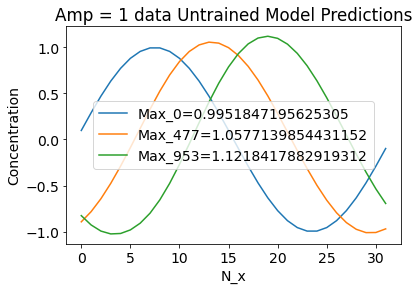

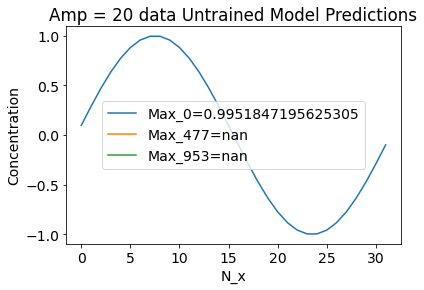

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


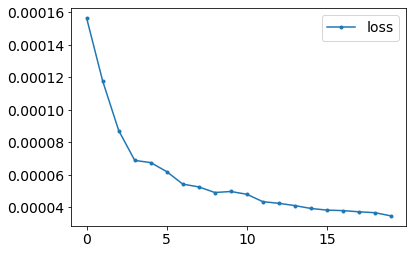

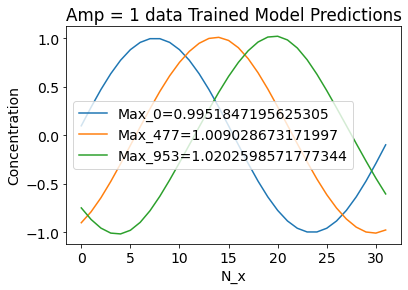

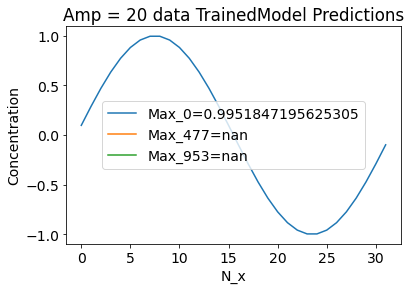

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


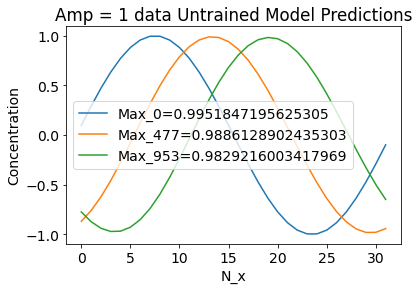

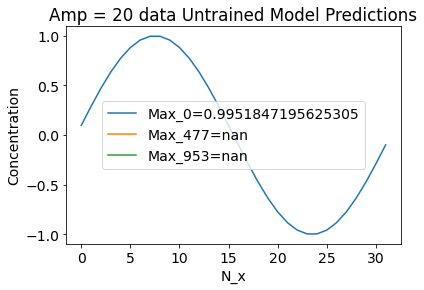

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


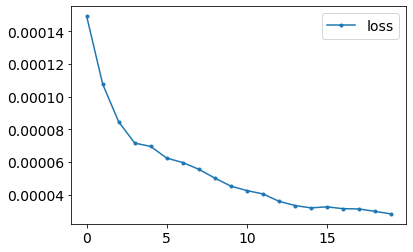

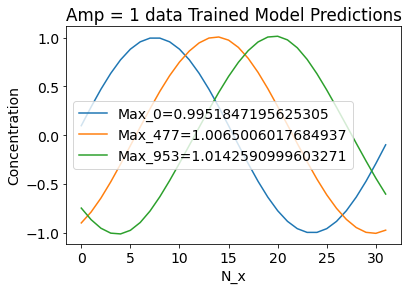

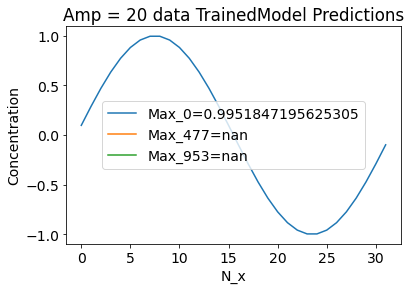

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


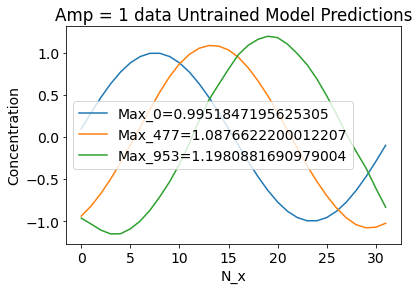

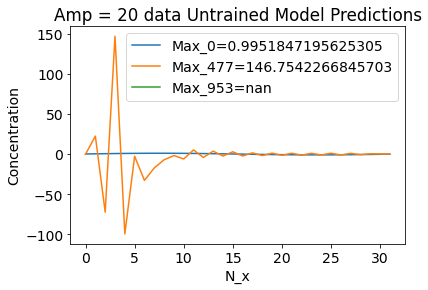

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


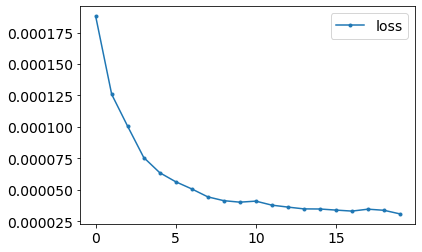

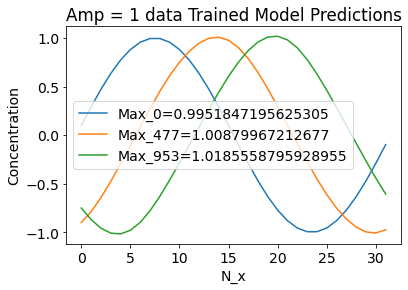

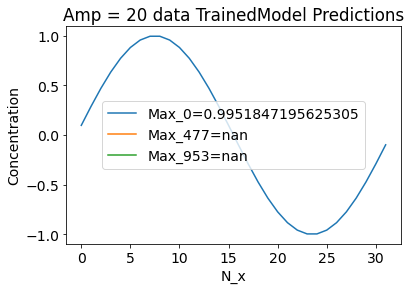

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


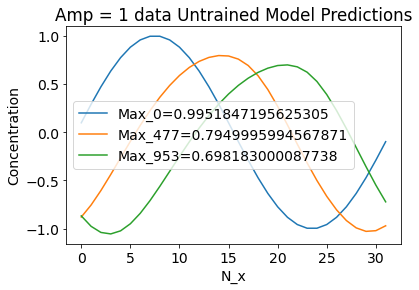

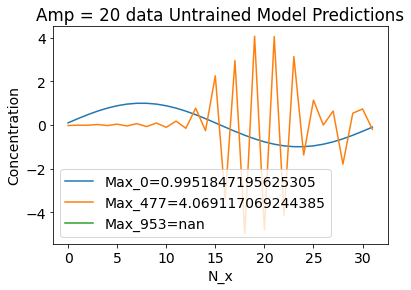

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


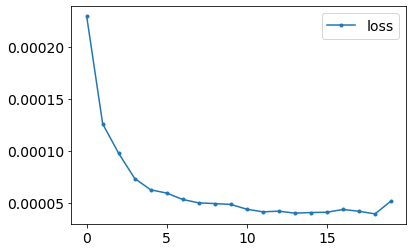

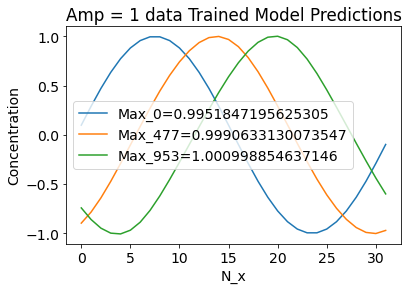

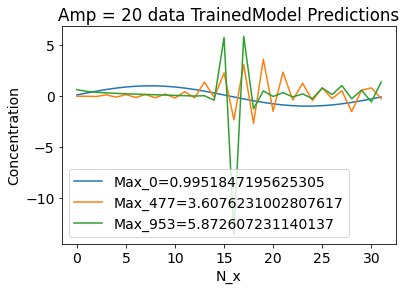

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


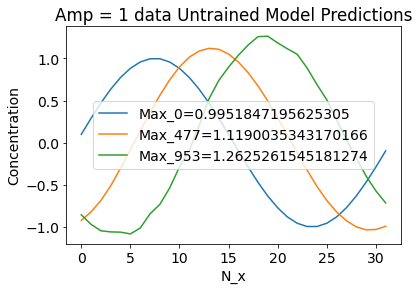

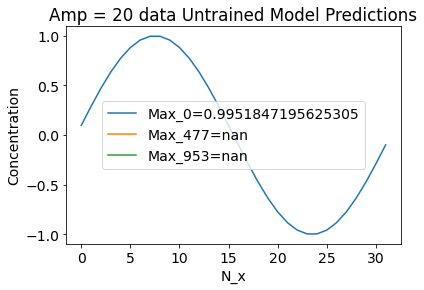

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


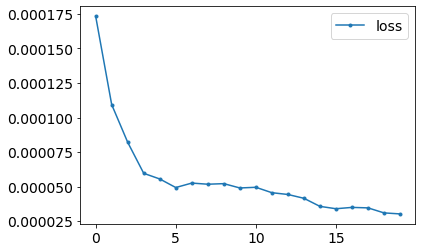

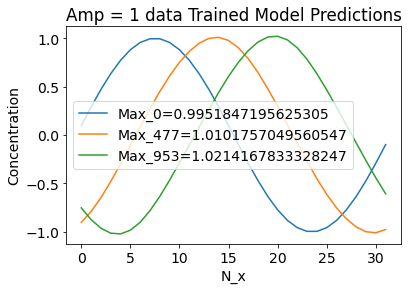

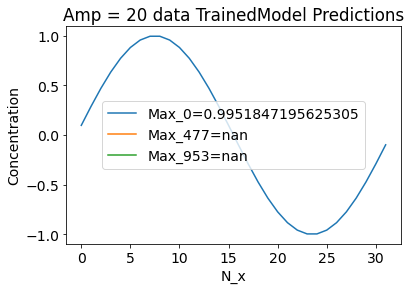

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


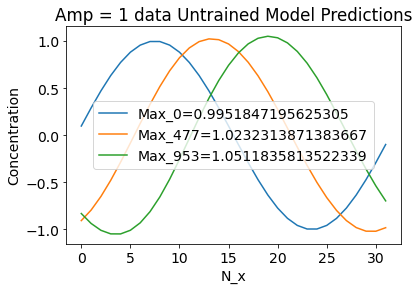

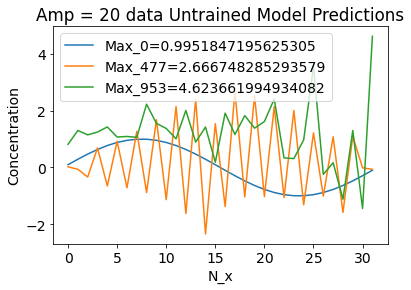

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


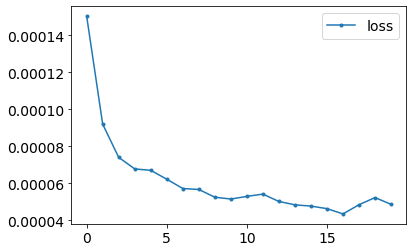

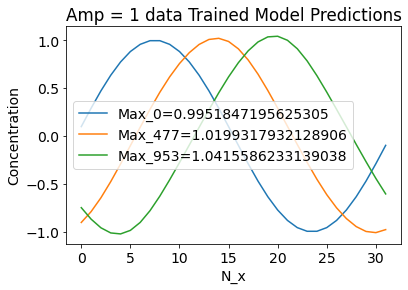

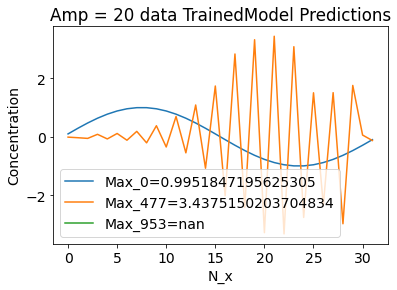

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


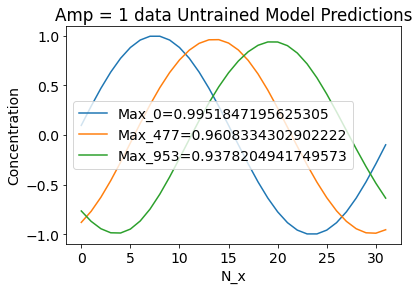

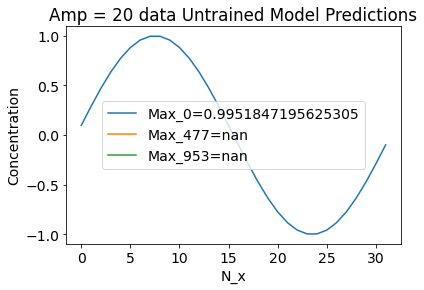

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


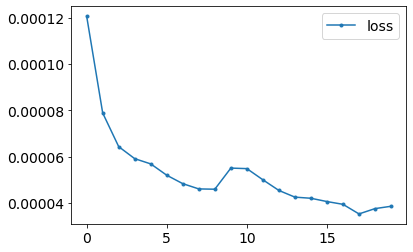

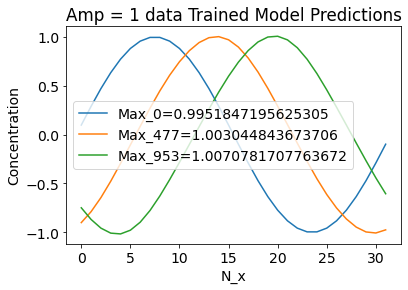

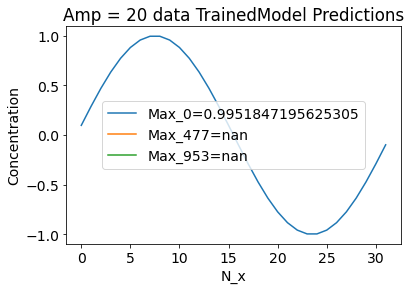

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


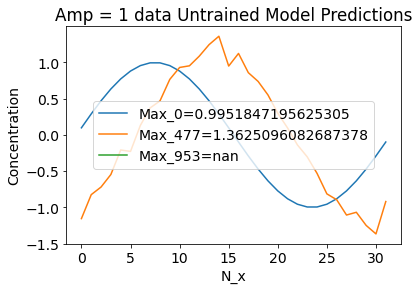

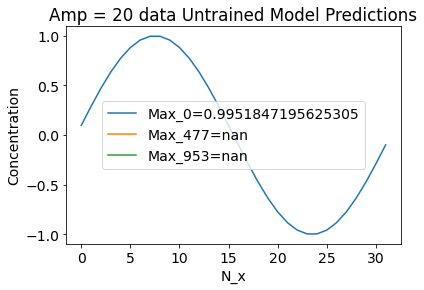

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


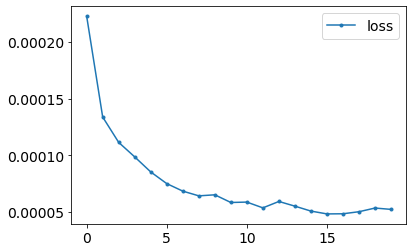

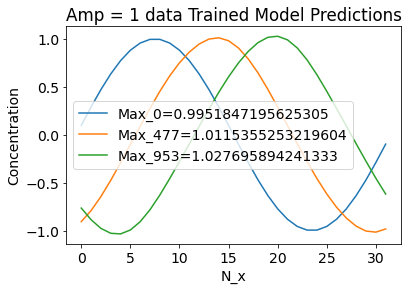

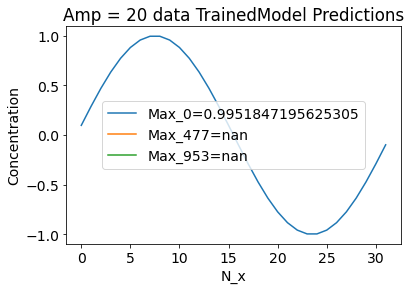

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


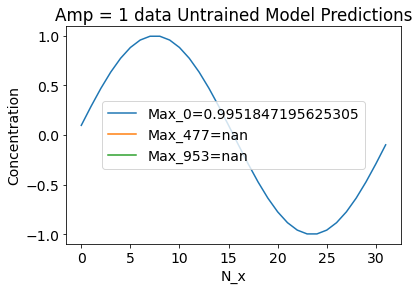

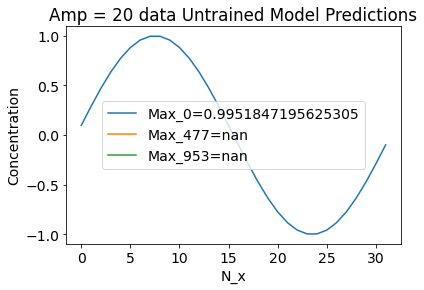

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


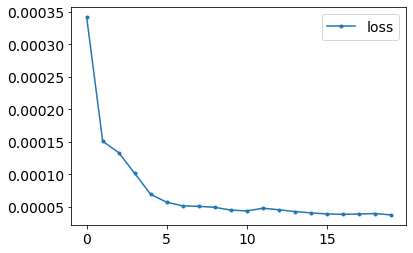

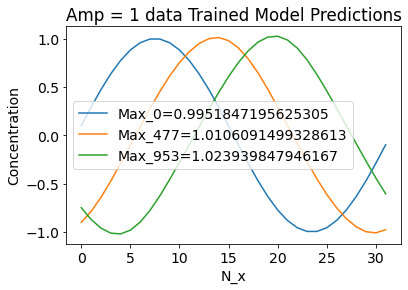

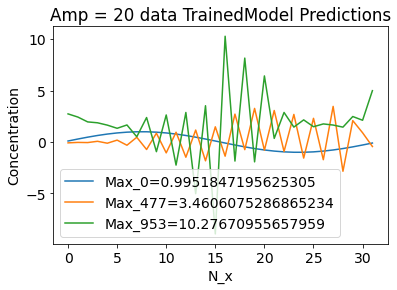

concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


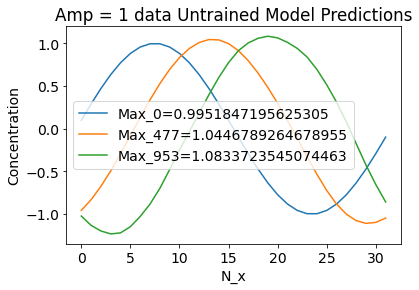

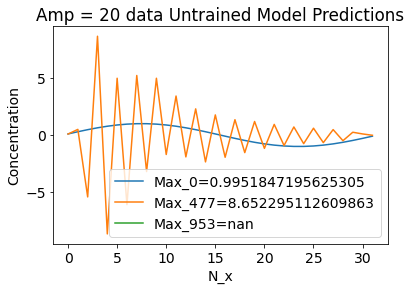

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


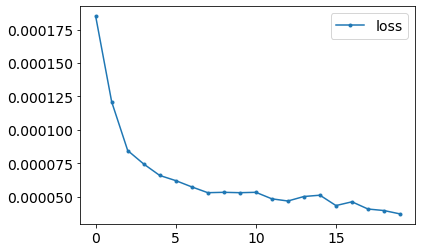

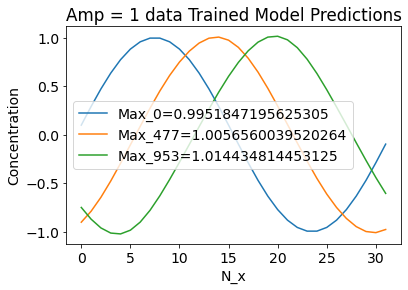

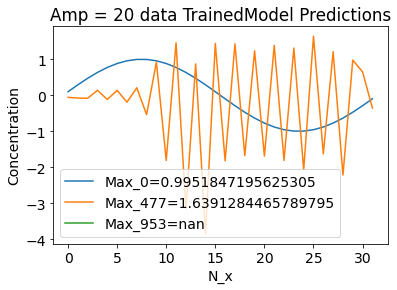

In [ ]:
'Non-linear initial conditions'
for seed in range(10):
  validate_k_a_p(kernel=3,init1=[[1],[1],[0]],init2=[[1],[1],[0]],ep=20,sd=seed)

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


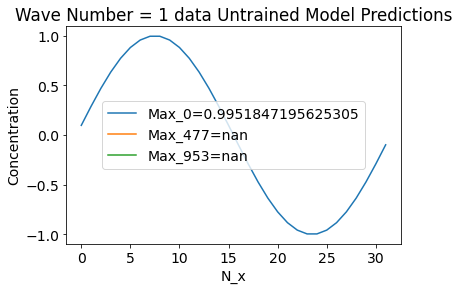

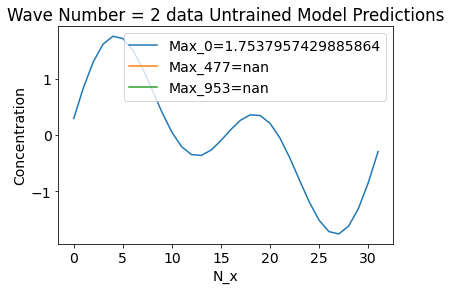

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


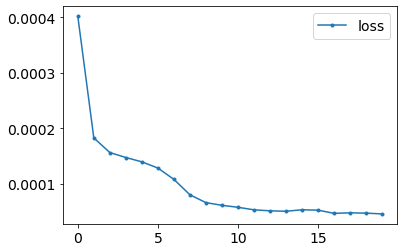

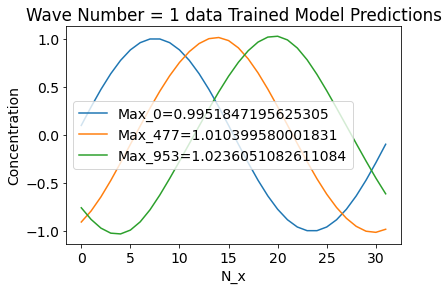

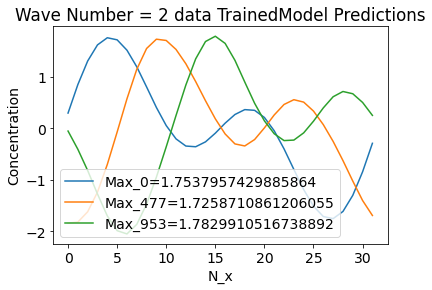

In [ ]:
'k varied'
validate_k_a_p(kernel=3,init1=[[1],[1],[0]],init2=[[1,1],[1,2],[0]])

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


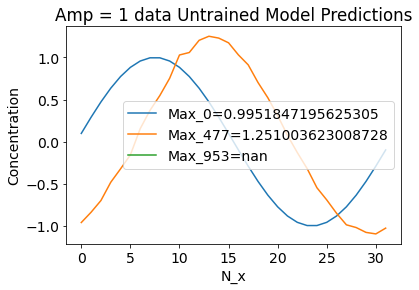

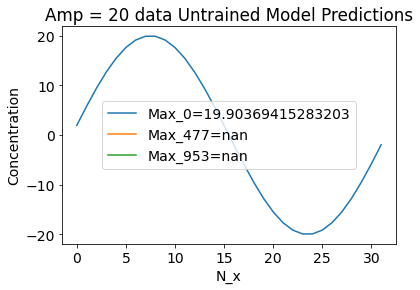

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


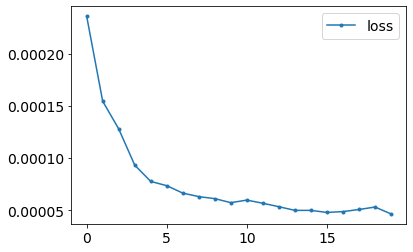

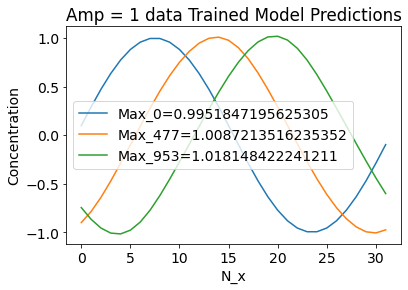

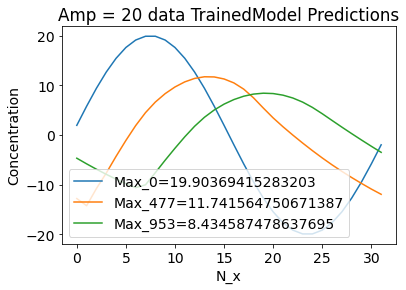

In [ ]:
'A varied'
validate_k_a_p(kernel=3,init1=[[1],[1],[0]],init2=[[20],[1],[0]])

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


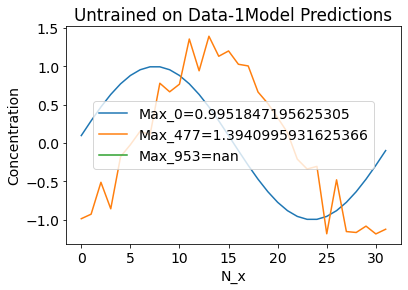

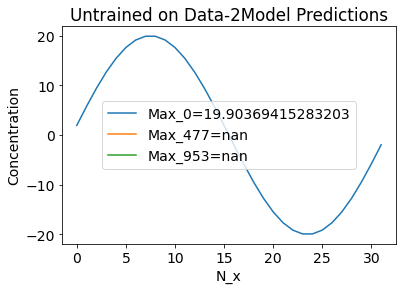

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


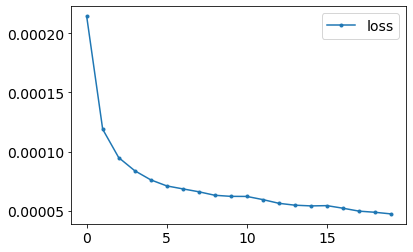

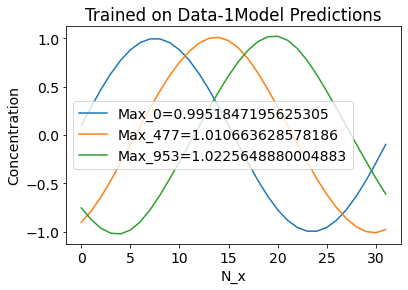

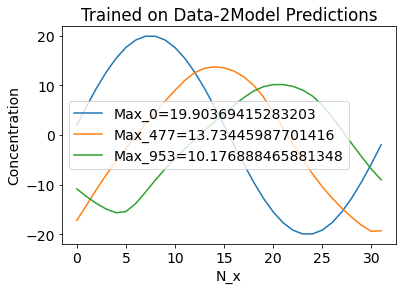

In [ ]:
'kernel varied'
validate_k_a_p(kernel=9,init1=[[1],[1],[0]],init2=[[1],[3],[0]])

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


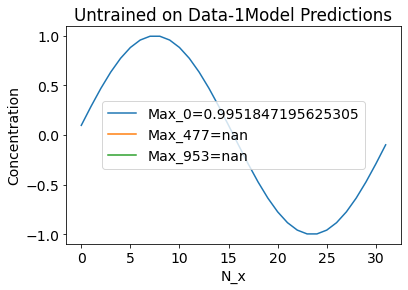

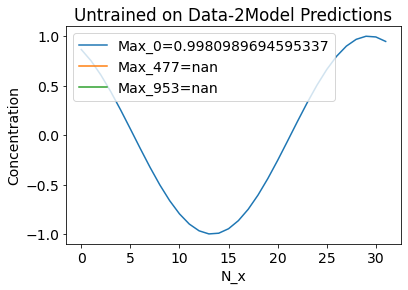

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


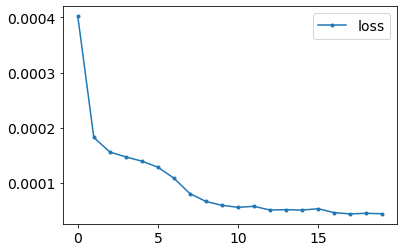

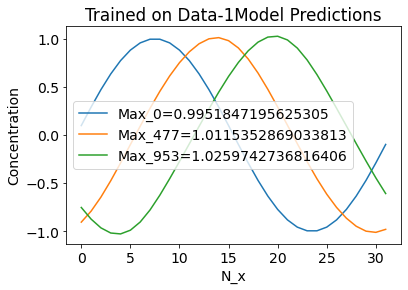

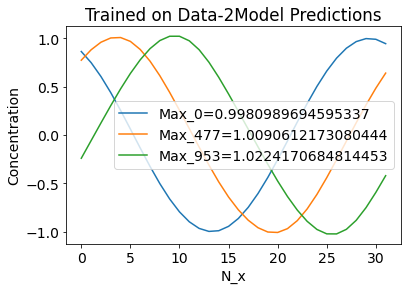

In [ ]:
'phi varied'
validate_k_a_p(kernel=3,init1=[[1],[1],[0]],init2=[[1],[1],[2]])

# Double Datasets training function
Train on Init-1 & Validate on Init-2

In [ ]:
'Train on 2 datasets of Amp = 1 each. '
'Validate on single dataset of Amp = 20'

def multi_train_validate(kernel,init1a,init1b,init2,ep=120):
  'Define params'
  fine_grid_resolution,grid_length =2**5,2*np.pi
  fine_grid = grids.Grid(
      size_x=fine_grid_resolution, size_y=1, 
      step=grid_length/fine_grid_resolution
      )
  x_fine, _ = fine_grid.get_mesh()
  CFL,u0,tend=0.08,1.,15.
  dx=grid_length/len(x_fine)
  dt=dx*CFL/u0
  N_t=int(tend//dt)
  time_steps=np.arange(N_t)
  print(x_fine.shape)

  
  data1a=solution_data(init1a[0],init1a[1],init1a[2],x_fine[:,0],N_t,dt)
  initial_state1a=create_init_state_from_2d_data(data1a,u0)

  data1b=solution_data(init1b[0],init1b[1],init1b[2],x_fine[:,0],N_t,dt)
  initial_state1b=create_init_state_from_2d_data(data1b,u0)

  data2=solution_data(init2[0],init2[1],init2[2],x_fine[:,0],N_t,dt)
  initial_state2=create_init_state_from_2d_data(data2,u0)

  model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,
    num_time_steps=4,stencil_size=3, kernel_size=(kernel,1), num_layers=5, filters=16,constrained_accuracy_order=1,
    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
  print(advection_equations.FiniteDifferenceAdvection(0.08).get_time_step(fine_grid,u0) == dt)
  tf.random.set_random_seed(23)

  'Untrained Evaluation'  
  integrated_UT1a = integrate.integrate_steps(model_nn, initial_state1a, time_steps)
  plot_time_prop(integrated_UT1a['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained on Data-1a')
  integrated_UT1b = integrate.integrate_steps(model_nn, initial_state1b, time_steps)
  plot_time_prop(integrated_UT1b['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained on Data-1b')

  integrated_UT2 = integrate.integrate_steps(model_nn, initial_state2, time_steps)
  plot_time_prop(integrated_UT2['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained on Data-2')

  'Training'
  model_nn.compile(optimizer='adam', loss='mae')

  ground_soln_dict=ground_dict_from_data(data1a)
  train_input, train_output = make_train_data(ground_soln_dict,data1a.shape[0]-1, 4)
  history = model_nn.fit(train_input, train_output, epochs=ep, batch_size=64, verbose=0, shuffle=True)
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()
  
  ground_soln_dict=ground_dict_from_data(data1b)
  train_input, train_output = make_train_data(ground_soln_dict,data1b.shape[0]-1, 4)
  history = model_nn.fit(train_input, train_output, epochs=ep, batch_size=64, verbose=0, shuffle=True)
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()

  'Trained Evaluation'
  integrated_T1a = integrate.integrate_steps(model_nn, initial_state1a, time_steps)
  plot_time_prop(integrated_T1a['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained on Data-1a')
  integrated_T1b = integrate.integrate_steps(model_nn, initial_state1b, time_steps)
  plot_time_prop(integrated_T1b['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained on Data-1b')

  integrated_T2 = integrate.integrate_steps(model_nn, initial_state2, time_steps)
  plot_time_prop(integrated_T2['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained on Data-2')


#  Results 2 datasets with same amplitudes

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


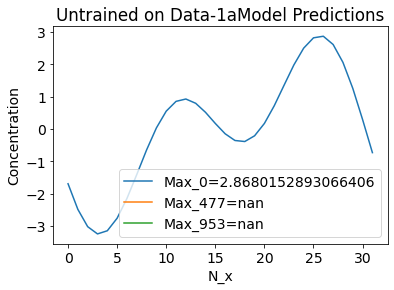

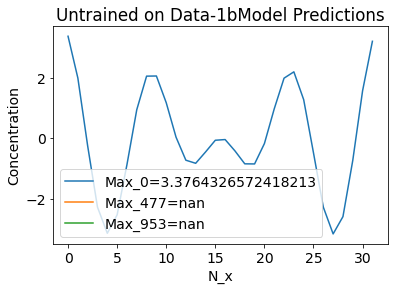

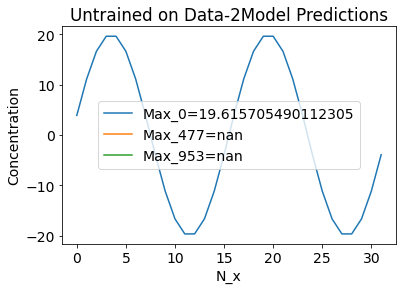

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


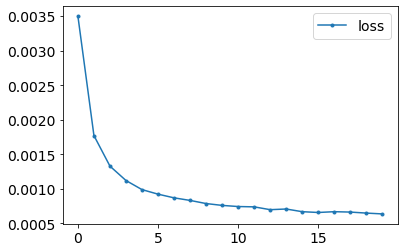

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


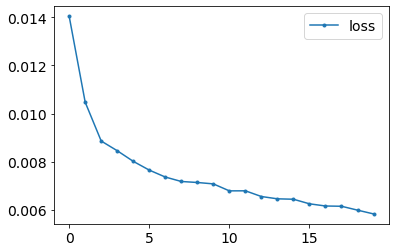

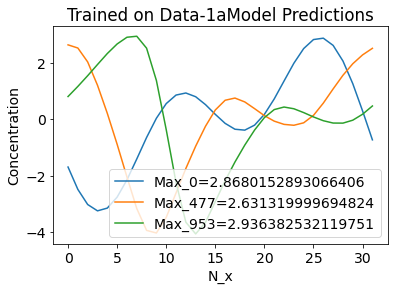

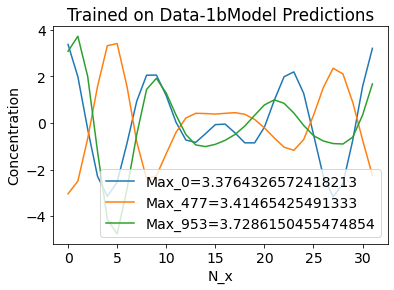

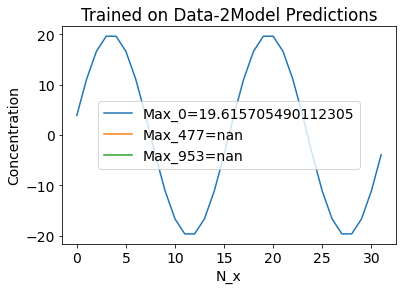

In [ ]:
multi_train_validate(3,init1a=[[1,1],[1,2],[3,4]],init1b=[[1,1],[3,4],[1,2]],init2=[[20],[2],[0]])

# Results 2 datasets with different amplitudes

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


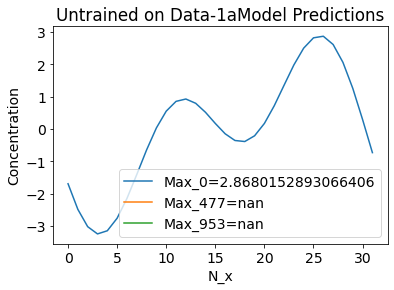

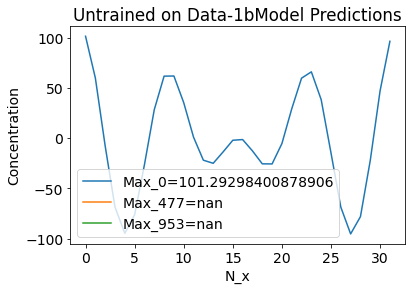

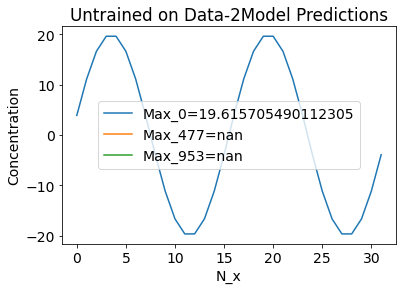

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


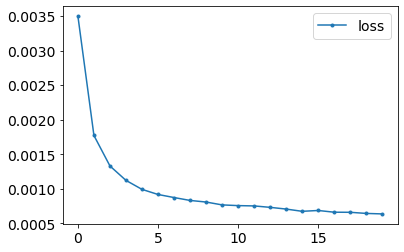

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


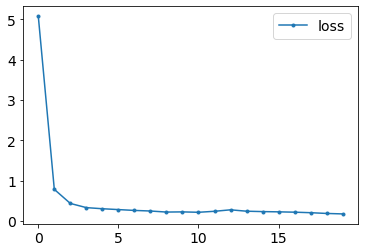

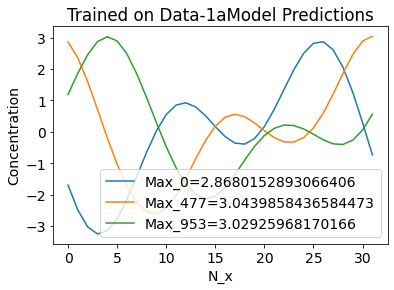

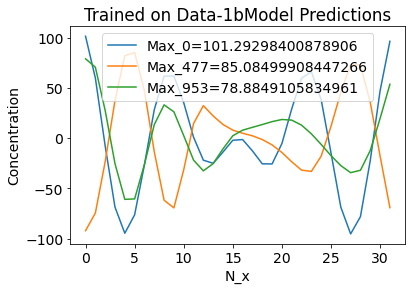

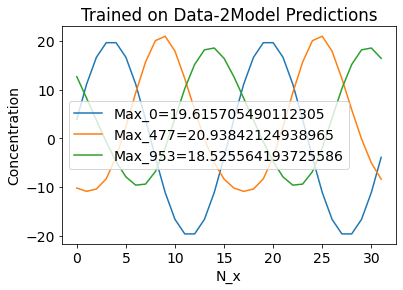

In [ ]:
multi_train_validate(3,init1a=[[1,1],[1,2],[3,4]],init1b=[[30,30],[3,4],[1,2]],init2=[[20],[2],[0]])

# Results 1 dataset with different amplitudes

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)
True


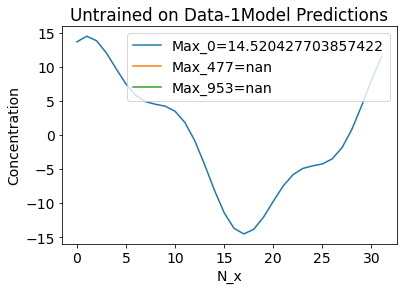

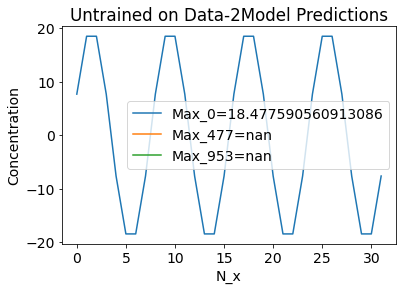

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (950, 32, 1)
x_velocity (950, 32, 1)
y_velocity (950, 32, 1)

 train_output shape: (950, 4, 32, 1)


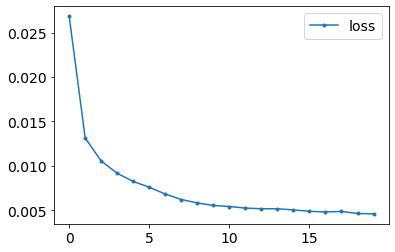

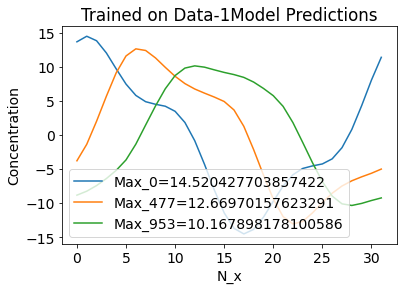

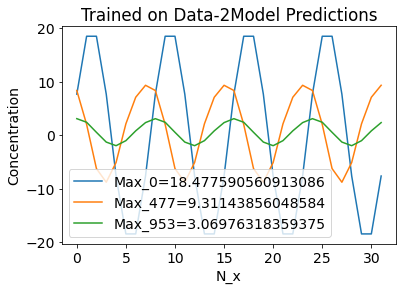

In [ ]:
validate_k_a_p(kernel=3,init1=[[1,3,10],[1,3,1],[0,2]],init2=[[20],[4],[0]])

# 2d array Extract_patches_2d

In [ ]:
x=tf.convert_to_tensor(np.arange(24.).reshape(6,4))
x

<tf.Tensor: id=775, shape=(6, 4), dtype=float64, numpy=
array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.],
       [16., 17., 18., 19.],
       [20., 21., 22., 23.]])>

In [ ]:
tensor_ops.extract_patches_2d(x,[2,3],[0,0])[1]

<tf.Tensor: id=805, shape=(4, 6), dtype=float64, numpy=
array([[3., 0., 1., 7., 4., 5.],
       [0., 1., 2., 4., 5., 6.],
       [1., 2., 3., 5., 6., 7.],
       [2., 3., 0., 6., 7., 4.]])>

# 1d array Extract_patches_2d

In [ ]:
x=tf.convert_to_tensor(np.arange(18).reshape(1,18))
x

<tf.Tensor: id=102597, shape=(1, 18), dtype=int64, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17]])>

In [ ]:
tensor_ops.extract_patches_2d(x,[12,3],[0,0])

InvalidArgumentError: ignored

# Variation stencil = 3 & kernel = 3

In [ ]:
vary_ks(3,3)

NameError: ignored

# Variation stencil = 4 & kernel = 3 

In [ ]:
# model_nn = models.PseudoLinearModel(
#       advection_equations.FiniteDifferenceAdvection(0.08), 
#       fine_grid,
#       num_time_steps=4,  # multi-step loss function
#       stencil_size=sten_size, kernel_size=(k_size,1), num_layers=4, filters=32,
#       constrained_accuracy_order=1, 
#       learned_keys = {'concentration_x', 'concentration_y'},  # finite volume view, use edge concentration
#       activation='relu',)

In [ ]:
vary_ks(7,3)

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)
True


InvalidArgumentError: ignored

In [ ]:
?vary_ks(5,13)

(16, 1)
concentration (1, 16, 1)
x_velocity (1, 16, 1)
y_velocity (1, 16, 1)
True


InvalidArgumentError: ignored

In [ ]:
tensor_

In [ ]:
'Doubt Send Nask'

# Calculate O.O.A

In [ ]:
type(err_ls)

numpy.ndarray

In [ ]:
plt.plot(np.log(ls),-1*np.log(ls)+intercept,'r',label=f'{slope} order accurate')
plt.plot(np.log(ls),np.log(err_ls),'b',label='Log-Error')
plt.xlabel('LogNx')
plt.xlabel('LogError')
plt.title('Order of Accuracy Plot')

NameError: ignored

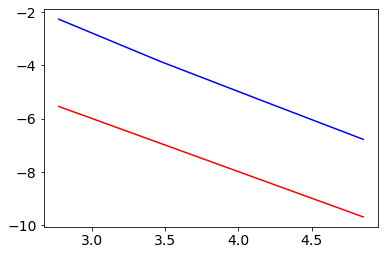

In [ ]:
plt.plot(np.log(ls),-2*np.log(ls),'r')
plt.plot(np.log(ls),np.log(err_ls),'b')

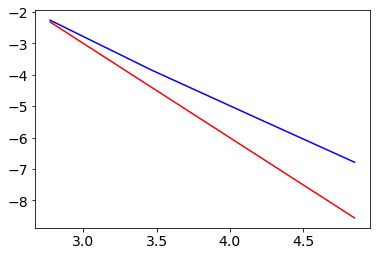

In [ ]:
plt.plot(np.log(ls),-3*np.log(ls)+6,'r')
plt.plot(np.log(ls),np.log(err_ls),'b')